# Final Project - Deep Learning - Test Notebook

---
<br>

### Name and ID:
Student 1: Osher Elhadad 318969748
<br>
Student 2: Gili Gutfeld 209284512

##**Libraries and default seed**

###**Import Libraries**

In [ ]:
import PIL
from PIL import Image
import imageio
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn
import torch.nn.functional
from torch.nn import init
import torch.optim
from torchvision.utils import make_grid
import numpy as np
from numpy import asarray
import pandas as pd
import os
import torch
import pickle
import random
from google.colab import files

###**Set Default Random Seed**

In [ ]:
def set_random_seed(seed):
    """
    Sets default random seeds.
    """
    # Set envarionment variable random seed
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Set the random seed of random, numpy and torch libraries
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(8)

#**CycleGAN - Monet paintings**

CycleGAN is a type of generative adversarial network (GAN) that is used to learn mapping functions between two domains in an unsupervised manner. Unlike traditional GANs that require paired data for training, CycleGAN can learn to map images from one domain to another domain without the need for paired data.

- [Paper](https://arxiv.org/pdf/1703.10593.pdf)
- [Original implementation](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

###**Custom Dataset**
We created a custom dataset that that normalizes the image. Also we covert 3x256x256 image to 3x320x320 as requested.

In [ ]:
class ImgDataset(Dataset):
    """
    Custom dataset for image
    """

    def __init__(self, paintings_dir, photo_name, img_size=320, normalize=True):
        self.paintings_dir = paintings_dir
        self.img_size = img_size

        # Define image transformations
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor()
            ])

        self.paintings_idx = dict()
        self.paintings_idx[0] = photo_name

    def __len__(self):
        return len(self.paintings_idx)

    def __getitem__(self, idx):
        # Determine the original index
        orig_idx = idx

        # Load the original image
        img_path = os.path.join(self.paintings_dir, self.paintings_idx[orig_idx])
        img = Image.open(img_path)
        img = self.transform(img)

        return img


def reverse_normalize(image, mean=0.5, std=0.5):
    """
    This function reverses the normalization process that was applied to an image
    when creating an ImgDataset object, and returns a numpy array of pixel values
    in the [0, 255] range.
    """
    
    # Convert input to numpy array if it's a PyTorch tensor
    if torch.is_tensor(image):
        image = image.detach().numpy()
    
    # Reverse the normalization by scaling back and shifting by the mean
    rev_normalized_img = image * std + mean
    
    # Scale the pixel values from [0, 1] range to [0, 255] range
    rev_normalized_img = rev_normalized_img * 255
    
    # Convert the pixel values to unsigned 8-bit integers
    return np.uint8(rev_normalized_img)

###**Generator model**

####**Convolution and Deconvolution**

In [ ]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=False, instance_norm=False):
    """
    Build a convolutional layer, with optional batch / instance normalization. 
    """
    
    layers = []
    conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(torch.nn.BatchNorm2d(out_channels))

    if instance_norm:
        layers.append(torch.nn.InstanceNorm2d(out_channels))
    return torch.nn.Sequential(*layers)

In [ ]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=False, instance_norm=False, dropout=False, dropout_ratio=0.5):
    """
    Build a transpose convolutional layer, with optional batch / instance normalization. 
    """
    
    layers = []
    layers.append(torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(torch.nn.BatchNorm2d(out_channels))
    
    if instance_norm:
        layers.append(torch.nn.InstanceNorm2d(out_channels))
    
    if dropout:
        layers.append(torch.nn.Dropout2d(dropout_ratio))
    
    return torch.nn.Sequential(*layers)

####**Residual Block**
The Residual Block is a building block commonly used in Residual Networks (ResNets) to improve the performance of deep neural networks. It addresses the vanishing gradient problem that occurs when training deep neural networks by allowing the network to learn identity mappings.

This Residual Block takes as input a feature map of size conv_dim and consists of two convolutional layers with 3x3 kernels and instance normalization. The convolutional layers use padding to maintain the spatial dimensions of the feature maps.

The output of the first convolutional layer is passed through a ReLU activation function, and the output of the second convolutional layer is added to the original input feature map. This addition operation creates a shortcut connection that allows the network to learn identity mappings. The output of the Residual Block is the sum of the input feature map and the output of the second convolutional layer.

In summary, the Residual Block architecture in your code uses two convolutional layers with instance normalization and a ReLU activation function, and a shortcut connection that adds the input feature map to the output of the second convolutional layer. This allows the network to learn identity mappings and improve the performance of deep neural networks. Used in the Generator architecture.

In [ ]:
class ResidualBlock(torch.nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        """
        Residual blocks with 2 convolution layers. 
        """
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1, instance_norm=True)
        
    def forward(self, x):
        out_1 = torch.nn.functional.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

####**Generator Model**
This is the generator architecture for a deep learning model used for image-to-image translation.

The generator takes an RGB image of size (320x320x3) as input and generates an RGB image of the same size as output.

The generator consists of three main parts: an encoder, a series of residual blocks, and a decoder.

The encoder downsamples the input image and extracts features from it. It consists of four convolutional layers with a kernel size of 9, 6 and 4, stride of 1, 2 and 2, and padding of 1. The number of output channels for each layer is doubled compared to the previous layer, starting from the initial number of channels set by the "conv_dim" parameter (which is set to 64 by default). Instance normalization is applied after the second, third, and fourth convolutional layers. After the last convolutional layer in the encoder, the output feature map size is (78, 78, 256).

The series of residual blocks is used to refine the features extracted by the encoder. The number of residual blocks is set by the "n_res_blocks" parameter, which is set to 6 by default. Each residual block has two convolutional layers with a kernel size of 3, stride of 1, and padding of 1. Instance normalization is applied after each convolutional layer. The residual block takes the output of the previous block as input and adds it to the output of the second convolutional layer before applying the ReLU activation function.

The decoder upsamples the refined features to generate the output image. It consists of four transposed convolutional layers with a kernel size of 4, 6 and 9, stride of 2, 2 and 1, and padding of 1. The number of output channels for each layer is halved compared to the previous layer, starting from the initial number of channels set by the "conv_dim" parameter (which is set to 64 by default). Instance normalization is applied after each transposed convolutional layer, except for the last one. The output of the last transposed convolutional layer is passed through a hyperbolic tangent activation function to generate the final output image.

Overall, this architecture follows the U-Net architecture which combines the contracting path (encoder) and the expanding path (decoder) of a neural network.

In [ ]:
class Generator(torch.nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(Generator, self).__init__()
        """
        Input- RGB image (320x320x3) and the output- RGB image (320x320x3)
        
        determine size = [(W−K+2P)/S]+1
        """
        
        #Encoder layers
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=9, stride=1) # (314, 314, 64)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=6, instance_norm=True) # (156, 156, 128)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, instance_norm=True) # (78, 78, 256)
        
        #Residual blocks (number depends on input parameter)
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = torch.nn.Sequential(*res_layers)
        
        #Decoder layers
        self.deconv4 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, instance_norm=True) # (156, 156, 128)
        self.deconv5 = deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=6, instance_norm=True) # (314, 314, 64)
        self.deconv6 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=9, stride=1, instance_norm=True) # (320, 320, 3)
        
    def forward(self, x):
        """
        Given an image x, returns a transformed image.
        """
        
        #Encoder
        out = torch.nn.functional.leaky_relu(self.conv1(x), negative_slope=0.2) # (314, 314, 64)
        out = torch.nn.functional.leaky_relu(self.conv2(out), negative_slope=0.2) # (156, 156, 128)
        out = torch.nn.functional.leaky_relu(self.conv3(out), negative_slope=0.2) # (78, 78, 256)
        
        #Residual blocks
        out = self.res_blocks(out)
        
        #Decoder
        out = torch.nn.functional.leaky_relu(self.deconv4(out), negative_slope=0.2) # (156, 156, 64)
        out = torch.nn.functional.leaky_relu(self.deconv5(out), negative_slope=0.2) # (314, 314, 64)
        out = torch.tanh(self.deconv6(out)) # (320, 320, 3)
        
        return out

###**Load The Trained CycleGAN Model**

In [ ]:
def load_generator_model(path_to_model, map_location=None):
    """
    Load a saved model
    """
    # Load the saved model weights and other state parameters from the checkpoint file
    model = Generator(conv_dim=64)
    model.load_state_dict(torch.load(path_to_model, map_location=map_location))
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Print a success message indicating that the model was loaded successfully
    print(' [*] model loaded successfully from %s' % path_to_model)

    # Return the loaded model
    return model

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1eSEFLkqou8WZ906PJ5sPQ0_y69KGYFWf
!unzip /content/best_exp.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eSEFLkqou8WZ906PJ5sPQ0_y69KGYFWf
To: /content/best_exp.zip
100% 85.4M/85.4M [00:00<00:00, 114MB/s] 
Archive:  /content/best_exp.zip
  inflating: discriminator_M.pkl     
  inflating: discriminator_P.pkl     
  inflating: generator_M_to_P.pkl    
  inflating: generator_P_to_M.pkl    


###**Show generated monet paintings**
Gets a 3x256x256 photo and generates a 3x320x320 monet painting

In [ ]:
uploaded_photo = files.upload()
image_name = list(uploaded_photo.keys())[0]
img = Image.open(image_name)

Saving 00882b7e1d.jpg to 00882b7e1d.jpg


 [*] model loaded successfully from /content/generator_P_to_M.pkl


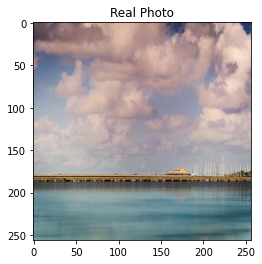

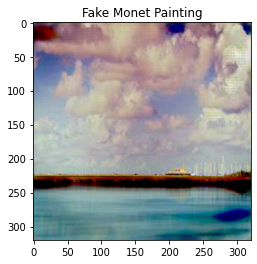

In [ ]:
G_P_to_M = load_generator_model('/content/generator_P_to_M.pkl')

path_photo = '/content/'

# Create dataset and dataloader
photo_dataset = ImgDataset(path_photo, image_name, img_size=320, normalize=True)
dataloader_P = DataLoader(photo_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
fixed_P = next(iter(dataloader_P))

#Identify correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#Create fake pictures for both cycles
fake_M = G_P_to_M(fixed_P.to(device))

tensor_img = transforms.Compose([
                transforms.ToTensor()
            ])(img)

#Generate grids
grid_P =  make_grid(tensor_img, nrow=4).permute(1, 2, 0).detach().cpu().numpy()
grid_fake_M =  make_grid(fake_M, nrow=4).permute(1, 2, 0).detach().cpu().numpy() 
    
#Normalize pictures to pixel range from 0 to 255
P, fake_M_ = reverse_normalize(grid_P, 0.5, 0.5), reverse_normalize(grid_fake_M, 0.5, 0.5)

plt.imshow(img)
plt.title('Real Photo')
plt.show()
plt.imshow(fake_M_)
plt.title('Fake Monet Painting')
plt.show()

#**Second Model - Neural Style Transfer (NST)**



###**Load Dataset**
Need a file named kaggle.json that was saved in drive (download it from kaggle user)

In [ ]:
! pip install -q kaggle
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1KlsP4zQG-yw4FIrNcT1PcgoRzPCHLJuF
!unzip /content/kaggle.zip
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c gan-getting-started
! mkdir train
! unzip gan-getting-started.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/photo_jpg/46e84039a1.jpg  
  inflating: train/photo_jpg/46f391abec.jpg  
  inflating: train/photo_jpg/46f5ef1042.jpg  
  inflating: train/photo_jpg/4706619607.jpg  
  inflating: train/photo_jpg/4707b03a08.jpg  
  inflating: train/photo_jpg/47100a9939.jpg  
  inflating: train/photo_jpg/471f4755b9.jpg  
  inflating: train/photo_jpg/472b351bc4.jpg  
  inflating: train/photo_jpg/472d5ac100.jpg  
  inflating: train/photo_jpg/4758e5dd4c.jpg  
  inflating: train/photo_jpg/4762bb79ef.jpg  
  inflating: train/photo_jpg/4778b13518.jpg  
  inflating: train/photo_jpg/4787b82d37.jpg  
  inflating: train/photo_jpg/478e07feaa.jpg  
  inflating: train/photo_jpg/478eb12a82.jpg  
  inflating: train/photo_jpg/479698b371.jpg  
  inflating: train/photo_jpg/4796d67f61.jpg  
  inflating: train/photo_jpg/47aad493bd.jpg  
  inflating: train/photo_jpg/47ae0edd23.jpg  
  inflating: train/photo_jpg/47b94957ff.jpg  
  inflating: train/photo_jpg/

###**Create datasets and dataloader**

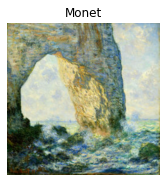

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Define a function to normalize the image data
def normalize(image):
  return tf.pow((tf.cast(image, tf.float32) / 127.5) / 2, 0.5) * 2 - 1

# Define a function to unnormalize the image data
def unnormalize(normalized_image):
  return tf.cast(tf.pow((normalized_image + 1) / 2, 2) * 255, tf.uint8)

# Define a function to load a TFRecord dataset from file names
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    return dataset.map(parse_example)

# Define a function to parse a single example from a TFRecord file
def parse_example(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, features)
    image = normalize(tf.image.decode_jpeg(example['image'], channels=3))
    image = tf.reshape(image, [*[256, 256], 3])
    return tf.image.resize(image, [320, 320])

# Split the Monet dataset into training and testing sets
path_monet = '/content/train/monet_tfrec/*.tfrec'
monet_filenames = tf.io.gfile.glob(path_monet)

# Load the training and testing datasets
monet_dataset = load_dataset(monet_filenames).batch(1)

# Display the first image from the Monet training datasets
monet_photo = next(iter(monet_dataset))

plt.subplot(1, 2, 1)
plt.title('Monet')
plt.imshow(unnormalize(monet_photo[0]))
plt.axis('off')

plt.show()

list_of_epochs = []
list_of_losses = []

##VGG Model

In [ ]:
class NSTModel():
        
  def __init__(self):
    self.style_layers = ['block1_conv1',
                         'block2_conv1', 
                         'block3_conv1', 
                         'block4_conv1',
                         'block5_conv1']
    self.content_layers = ['block5_conv2']

    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    self.style_model = tf.keras.models.Model(inputs=self.vgg.input,
                                             outputs=[self.vgg.get_layer(layer).output for layer in self.style_layers])
    self.content_model = tf.keras.models.Model(inputs=self.vgg.input,
                                               outputs=[self.vgg.get_layer(layer).output for layer in self.content_layers])

    self.num_of_iterations = 500
    self.beta_1 = 0.99
    self.learning_rate = 0.01
    self.weight_decay = 0.01
    self.style_image = None

  def style_loss(self, style, generated):
      style_gram = self.gram_matrix(style)
      generated_gram = self.gram_matrix(generated)
      return tf.reduce_mean(tf.square(style_gram - generated_gram))

  def content_loss(self, image, style):
      return tf.reduce_mean(tf.square(image - style))

  def total_loss(self, image):
      x = tf.reduce_mean(tf.square(image[:, :, :-1, :] - image[:, :, 1:, :]))
      y = tf.reduce_mean(tf.square(image[:, :-1, :, :] - image[:, 1:, :, :]))
      return x + y

  def gram_matrix(self, input):
      channels = int(input.shape[-1])
      a = tf.reshape(input, [-1, channels])
      n = tf.shape(a)[0]
      return tf.matmul(a, a, transpose_a=True) / tf.cast(n, tf.float32)

  def train(self, monet_dataset):
    for image in monet_dataset.take(1):
      self.style_image = image

  def generate(self, content_image, loss_visualize = False):
    generated_image = tf.Variable(content_image)
    optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate,
                                   beta_1=self.beta_1, 
                                   epsilon=0.1,
                                   weight_decay=self.wd)
    
    for i in range(self.num_of_iterations):
      with tf.GradientTape() as tape:
          content_features = self.content_model(content_image)
          generated_features = self.content_model(generated_image)
          loss1 = self.content_loss(content_features[0], generated_features[0])
      
          style_features = self.style_model(self.style_image)
          generated_features = self.style_model(generated_image)
          loss2 = 0
          for j in range(len(self.style_layers)):
              loss2 += self.style_loss(style_features[j], generated_features[j])

          loss3 = self.total_loss(generated_image)
          loss2 = loss2 / len(self.style_layers)
          t_loss = 1e4 * loss1 + 0.01 * loss2 + 1e3 * loss3
      
      gradients = tape.gradient(t_loss, generated_image)
      optimizer.apply_gradients([(gradients, generated_image)])
      generated_image.assign(tf.clip_by_value(generated_image, 0, 255))
      
      if loss_visualize:
        print("iteration: {}, total loss: {}".format(i + 1, t_loss))
        list_of_epochs.append(i + 1)
        list_of_losses.append(t_loss)
   
    return generated_image

(320, 320, 3)


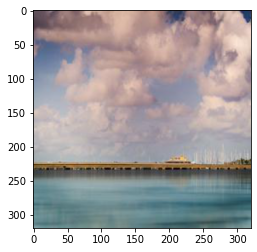

In [ ]:
tensor_img = normalize(tf.convert_to_tensor(asarray(img)))
content_img = tf.image.resize(tensor_img, [320,320])
print(content_img.shape)
plt.imshow(unnormalize(content_img))
plt.show()

##Test Model

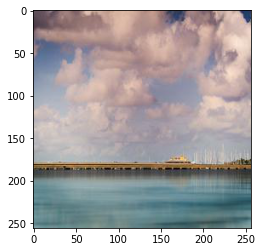

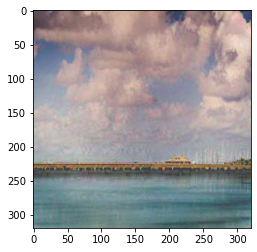

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

model = NSTModel()
model.num_of_iterations = 400
model.learning_rate = 0.01
model.wd = 0.01
model.beta_1 = 0.5
model.train(monet_dataset)

input_img_content = tf.convert_to_tensor(np.expand_dims(content_img, axis=0))
plt.imshow(img)
plt.show()

prediction = model.generate(input_img_content)[0].numpy()
plt.imshow(unnormalize(prediction))
plt.show()